## Applies COMMOT to HVGs, SVGs, and unfiltered expression data set for mouse brain ST 

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import commot as ct
import os
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import anndata as ad

### Prepare data for COMMOT input
- align by barcode 
- get non negative expression matrix

In [2]:
# load in mouse seurat object
mouse_seurat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/seurat_objs", "mousebrain_seurat.rds")

# read in mouse seurat object
base = importr('base')
seurat_obj = base.readRDS(mouse_seurat)


R callback write-console: Loading required namespace: SeuratObject
  


In [3]:
# load in mouse data HVGs and SVGs - using unLR filtered data
# sorted by p value in ascending order
hvg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/hvgs", "mouse_hvg_gene_cell_matrix.csv")
svg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/svgs", "nnSVG_mouse_svg_gene_cell_matrix.csv")

In [4]:
# check first lines of HVG and SVG gene cell matrices
hvg_df = pd.read_csv(hvg_gene_cell_mat, index_col=0)
svg_df = pd.read_csv(svg_gene_cell_mat, index_col=0)

hvg_df.head() # gene by spot matrix
#svg_df.head()

,AAACAAGTATCTCCCA.1,AAACAGAGCGACTCCT.1,AAACAGGGTCTATATT.1,AAACATTTCCCGGATT.1,AAACCCGAACGAAATC.1,AAACCGGAAATGTTAA.1,AAACCGGGTAGGTACC.1,AAACGAGACGGTTGAT.1,AAACTGCTGGCTCCAA.1,AAACTTGCAAACGTAT.1,...,TTGTGAGGCATGACGC.1,TTGTGCAGCCACGTCA.1,TTGTGGCCCTGACAGT.1,TTGTGTATGCCACCAA.1,TTGTGTTTCCCGAAAG.1,TTGTTAGCAAATTCGA.1,TTGTTCAGTGTGCTAC.1,TTGTTGTGTGTCAAGA.1,TTGTTTCATTAGTCTA.1,TTGTTTCCATACAACT.1
Ttr,1.609438,0.000000,1.098612,0.693147,6.200509,1.609438,1.098612,2.197225,1.791759,0.000000,...,0.693147,1.386294,0.693147,1.386294,1.386294,0.000000,0.000000,1.098612,2.397895,1.098612
Ptgds,2.397895,5.252273,3.871201,2.197225,5.398163,3.555348,2.079442,2.564949,5.176150,3.663562,...,2.079442,2.995732,2.397895,5.991465,6.785588,2.564949,5.135798,1.609438,2.079442,2.772589
Plp1,5.446737,0.693147,4.454347,5.863631,5.003946,4.204693,2.639057,1.791759,2.484907,3.951244,...,2.890372,5.583496,1.386294,4.634729,1.609438,3.044522,2.708050,0.693147,3.850148,4.143135
Pcp2,0.693147,3.583519,0.000000,0.693147,1.386294,0.000000,0.000000,2.079442,1.386294,0.000000,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,1.098612,4.158883,0.000000,0.000000
Car8,0.000000,2.639057,0.000000,1.098612,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,...,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.693147,3.931826,0.693147,0.000000


In [5]:
# convert matrices to gene lists
SVG = set(svg_df.index.tolist())
HVG = set(hvg_df.index.tolist())

In [6]:
# look at lists
print(f"First 10 HVGs: {list(HVG)[:10]}")
print(f"First 10 SVGs: {list(SVG)[:10]}")

First 10 HVGs: ['Bin1', 'Parvb', 'Zfp598', 'Frmpd4', 'Zfr2', 'Pcyt2', 'Asphd1', 'Snx4', 'Iqcb1', 'Sgip1']
First 10 SVGs: ['Bin1', 'Parvb', 'Frmpd4', 'Zfp598', 'Zfr2', 'Pcyt2', 'Asphd1', 'Snx4', 'Plxnc1', 'Hyal2']


In [7]:
# get non negative expression and coordiantes from mouse seurat

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# load in seurat object
ro.r('library(Seurat)')
ro.r('obj <- readRDS("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/seurat_objs/mousebrain_seurat.rds")')

R callback write-console: Loading required package: SeuratObject
  
R callback write-console: Loading required package: sp
  
R callback write-console: 
Attaching package: ‘SeuratObject’

  
R callback write-console: The following objects are masked from ‘package:base’:

    intersect, t

  



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [8]:
# look for images slot
print(ro.r('head(colnames(obj@meta.data), 50)'))  # show first 50 meta columns

 [1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "cell_id"      "x"           
 [6] "y"            "percent.mt"   "imagerow"     "imagecol"     "nCount_SCT"  
[11] "nFeature_SCT"



In [9]:
# Get meta.data with rownames kept as a column
md = ro.r('''
md <- obj@meta.data
md$barcode <- rownames(md)
md[, c("barcode", "cell_id", "imagecol", "imagerow", "x", "y")]
''')
md = pandas2ri.rpy2py(md)

# check types 
md["barcode"] = md["barcode"].astype(str)
md["cell_id"] = md["cell_id"].astype(str)
md = md.dropna(subset=["cell_id"])

# check matches between svg spot ids and meta data cell ids/barcodes
spot_ids_csv = pd.Index(svg_df.columns.astype(str))

# check matches
n_match_cellid = spot_ids_csv.isin(pd.Index(md["cell_id"])).sum()
n_match_barcode = spot_ids_csv.isin(pd.Index(md["barcode"])).sum()

print("CSV→cell_id matches:", n_match_cellid, "of", len(spot_ids_csv))
print("CSV→barcode matches:", n_match_barcode, "of", len(spot_ids_csv))

CSV→cell_id matches: 0 of 1640
CSV→barcode matches: 0 of 1640


In [ ]:
# show spot ids
print("CSV examples:", spot_ids_csv[:20].tolist())


CSV examples: ['AAACAAGTATCTCCCA.1', 'AAACAGAGCGACTCCT.1', 'AAACAGGGTCTATATT.1', 'AAACATTTCCCGGATT.1', 'AAACCCGAACGAAATC.1', 'AAACCGGAAATGTTAA.1', 'AAACCGGGTAGGTACC.1', 'AAACGAGACGGTTGAT.1', 'AAACTGCTGGCTCCAA.1', 'AAACTTGCAAACGTAT.1', 'AAAGCTTGCCTACATA.1', 'AAAGTGTGATTTATCT.1', 'AAAGTTGACTCCCGTA.1', 'AAATAAGGTAGTGCCC.1', 'AAATACCTATAAGCAT.1', 'AAATAGCTTAGACTTT.1', 'AAATAGGGTGCTATTG.1', 'AAATCGCGGAAGGAGT.1', 'AAATCTAGCCCTGCTA.1', 'AAATGATTCGATCAGC.1']


In [10]:
# get seurat barcodes
seurat_barcodes = list(ro.r('rownames(obj@meta.data)'))
seurat_barcodes = [str(x) for x in seurat_barcodes]

print("Seurat n spots:", len(seurat_barcodes))
print("CSV n spots:", svg_df.shape[1])

Seurat n spots: 1640
CSV n spots: 1640


In [ ]:
# map csv columns to seurat barcodes by order
assert svg_df.shape[1] == len(seurat_barcodes), "Counts differ —> can't map by order"

# rename csv columns to seurat barcodes
svg_df.columns = seurat_barcodes
hvg_df.columns = seurat_barcodes


In [12]:
# show renamed svg spot ids
print(pd.Index(svg_df.columns.astype(str))[:20].tolist())

# check overlap between seurat barcodes and csv barcodes
seurat_barcodes = pd.Index([str(x) for x in ro.r('colnames(obj)')])
csv_barcodes = pd.Index(svg_df.columns.astype(str))

print("Seurat n:", len(seurat_barcodes))
print("CSV n:", len(csv_barcodes))
print("Overlap:", len(seurat_barcodes.intersection(csv_barcodes)))
print("Seurat example:", seurat_barcodes[:5].tolist())

['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1', 'AAACGAGACGGTTGAT-1', 'AAACTGCTGGCTCCAA-1', 'AAACTTGCAAACGTAT-1', 'AAAGCTTGCCTACATA-1', 'AAAGTGTGATTTATCT-1', 'AAAGTTGACTCCCGTA-1', 'AAATAAGGTAGTGCCC-1', 'AAATACCTATAAGCAT-1', 'AAATAGCTTAGACTTT-1', 'AAATAGGGTGCTATTG-1', 'AAATCGCGGAAGGAGT-1', 'AAATCTAGCCCTGCTA-1', 'AAATGATTCGATCAGC-1']
Seurat n: 1640
CSV n: 1640
Overlap: 1640
Seurat example: ['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1']


In [13]:
# get coordinates
coords = ro.r('''
md <- obj@meta.data
md[, c("imagecol","imagerow")]
''')
coords = pandas2ri.rpy2py(coords)
coords.index = coords.index.astype(str)
coords.columns = ["x", "y"]  


print(coords.head()) # cell ID by location

                         x       y
AAACAAGTATCTCCCA-1  7410.0  8455.0
AAACAGAGCGACTCCT-1  3097.0  7905.0
AAACAGGGTCTATATT-1  7050.0  2327.0
AAACATTTCCCGGATT-1  8728.0  8111.0
AAACCCGAACGAAATC-1  6811.0  9351.0


In [16]:
# get counts
expr_df = ro.r('''
mat <- NULL
try({ mat <- GetAssayData(obj, assay="SCT", slot="counts") }, silent=TRUE)
if (is.null(mat)) {
  try({ mat <- GetAssayData(obj, assay="SCT", layer="counts") }, silent=TRUE)
}
if (is.null(mat)) stop("Couldn't access SCT counts.")
as.data.frame(as.matrix(mat))
''')
expr_df = pandas2ri.rpy2py(expr_df)
expr_df.index = expr_df.index.astype(str) # genes
expr_df.columns = expr_df.columns.astype(str)  # barcodes

print("expr_df shape (genes x spots):", expr_df.shape)
print(expr_df.head())  # first 5 spots

expr_df shape (genes x spots): (16112, 1640)
        AAACAAGTATCTCCCA-1  AAACAGAGCGACTCCT-1  AAACAGGGTCTATATT-1  \
Xkr4                   0.0                 0.0                 0.0   
Sox17                  0.0                 0.0                 0.0   
Mrpl15                 0.0                 1.0                 1.0   
Lypla1                 0.0                 0.0                 0.0   
Tcea1                  0.0                 1.0                 0.0   

        AAACATTTCCCGGATT-1  AAACCCGAACGAAATC-1  AAACCGGAAATGTTAA-1  \
Xkr4                   0.0                 0.0                 0.0   
Sox17                  0.0                 0.0                 1.0   
Mrpl15                 0.0                 0.0                 1.0   
Lypla1                 0.0                 0.0                 0.0   
Tcea1                  2.0                 0.0                 0.0   

        AAACCGGGTAGGTACC-1  AAACGAGACGGTTGAT-1  AAACTGCTGGCTCCAA-1  \
Xkr4                   0.0                 

In [18]:
# align by barcodes
common = csv_barcodes.intersection(expr_df.columns).intersection(coords.index)
print("Common spots:", len(common))

# subset to common spots
expr_df = expr_df.loc[:, common]
coords_sub = coords.loc[common]

# nonnegative expression for COMMOT
expr_df = np.log1p(expr_df)

# spots x genes
spot_gene_mat = expr_df.T
print("Spots by gene shape:", spot_gene_mat.shape)

Common spots: 1640
Spots by gene shape: (1640, 16112)


In [23]:
# build AnnData object for COMMOT

adata = ad.AnnData(X=spot_gene_mat.values)
adata.obs_names = spot_gene_mat.index.astype(str)
adata.var_names = spot_gene_mat.columns.astype(str)
adata.obsm["spatial"] = coords_sub.loc[adata.obs_names, ["x","y"]].values

print("adata:", adata.shape)
print("spatial:", adata.obsm["spatial"].shape)
print("X min:", adata.X.min())

adata: (1640, 16112)
spatial: (1640, 2)
X min: 0.0


### Filter for LR pairs using CellChat

In [35]:
# get mouse LR pairs from CellChat
df_lr = ct.pp.ligand_receptor_database(database="CellChat", species="Mouse")

# filter for LR pairs present in data
df_lr_expr = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="min_cell_pct",
                                      min_cell_pct=0.05)

# SVG/HVG filtering
def receptor_in_set(rec, geneset):
    return any(p in geneset for p in str(rec).split("_"))

df_lr_svg = df_lr_expr[df_lr_expr.iloc[:,0].isin(SVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, SVG))].copy()
df_lr_hvg = df_lr_expr[df_lr_expr.iloc[:,0].isin(HVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, HVG))].copy()

# LR df for unfiltered data
df_lr_unfiltered = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="none")

In [25]:
# look at lr dataframes
print("SVG LR dataframe:")
print(df_lr_svg.head())
print("n LR pairs:", df_lr_svg.shape[0])

SVG LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 169


In [26]:
print("HVG LR dataframe:")
print(df_lr_hvg.head())
print("n LR pairs:", df_lr_hvg.shape[0])

HVG LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 169


In [36]:
print("Unfiltered LR dataframe:")
print(df_lr_unfiltered.head())
print("n LR pairs:", df_lr_unfiltered.shape[0])

Unfiltered LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 589


In [28]:
# ligand/receptor columns
lig_col = df_lr.columns[0]
rec_col = df_lr.columns[2]

print(f"First 10 ligand names: {df_lr[lig_col].dropna().astype(str).tolist()[:10]}")
print(f"First 10 receptor names: {df_lr[rec_col].dropna().astype(str).tolist()[:10]}")

def split_parts(x):
    if pd.isna(x):
        return []
    # if receptor stored as list/tuple/set
    if isinstance(x, (list, tuple, set)):
        parts = []
        for y in x:
            parts.extend(str(y).split("_"))
        return parts
    return str(x).split("_")

lr_ligands = set(df_lr[lig_col].dropna().astype(str))
lr_receptors = set(p for r in df_lr[rec_col].dropna() for p in split_parts(r))
lr_genes = lr_ligands | lr_receptors

print("Using columns:", lig_col, rec_col)
print("LR genes:", len(lr_genes))
print("LR ∩ SVG:", len(lr_genes & SVG))
print("LR ∩ HVG:", len(lr_genes & HVG))
print("LR ∩ SVG ∩ HVG:", len(lr_genes & SVG & HVG))
print("SVG-only within LR:", len((lr_genes & SVG) - HVG))
print("HVG-only within LR:", len((lr_genes & HVG) - SVG))


First 10 ligand names: ['Tgfb1', 'Tgfb2', 'Tgfb3', 'Tgfb1', 'Tgfb1', 'Tgfb2', 'Tgfb2', 'Tgfb3', 'Tgfb3', 'Tgfb1']
First 10 receptor names: ['TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb']
Using columns: 0 2
LR genes: 502
LR ∩ SVG: 69
LR ∩ HVG: 93
LR ∩ SVG ∩ HVG: 64
SVG-only within LR: 5
HVG-only within LR: 29


In [ ]:
# colnames in lr df
LIG = "0"
REC = "1"
PATH = "2"
CAT = "3"  

# make copies & ensure strings
lr_df = df_lr.copy()
lr_df[LIG] = lr_df[LIG].astype(str)
lr_df[REC] = lr_df[REC].astype(str)

varset = set(adata.var_names)

def receptor_parts(rec: str):
    # heteromeric receptors are encoded as "A_B_C"
    return str(rec).split("_")

def receptor_in_var(rec: str) -> bool:
    parts = receptor_parts(rec)
    return any(p in varset for p in parts)

def receptor_in_set(rec: str, geneset: set) -> bool:
    parts = receptor_parts(rec)
    return any(p in geneset for p in parts)

# filter LR pairs to those present in the dataset
lr_expr = lr_df[
    lr_df[LIG].isin(varset) &
    lr_df[REC].apply(receptor_in_var)
].copy()

# SVG / HVG LR filters 
lr_svg = lr_expr[
    lr_expr[LIG].isin(SVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))
].copy()

lr_hvg = lr_expr[
    lr_expr[LIG].isin(HVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))
].copy()

print("LR total:", lr_df.shape)
print("LR expressed in data:", lr_expr.shape)
print("LR SVG-filtered:", lr_svg.shape)
print("LR HVG-filtered:", lr_hvg.shape)


LR total: (1209, 4)
LR expressed in data: (596, 4)
LR SVG-filtered: (484, 4)
LR HVG-filtered: (519, 4)


## Use stricter rules on LR filtering pairings
- ligand and receptor must be an SVG or HVG
- ligand must be a SVG or HVG
- receptor must be a SVG or HVG
- prevalence:
    - ligand and at least one receptor part expressed in at least 5% of spots

In [37]:
# filter based on LR both must be SVG or HVG
lr_svg_strict = lr_expr[
    lr_expr[LIG].isin(SVG) &
    lr_expr[REC].apply(lambda r: all(p in SVG for p in receptor_parts(r)))
].copy()

lr_hvg_strict = lr_expr[
    lr_expr[LIG].isin(HVG) &
    lr_expr[REC].apply(lambda r: all(p in HVG for p in receptor_parts(r)))
].copy()

print("LR SVG-strict filtered:", lr_svg_strict.shape)
print("LR HVG-strict filtered:", lr_hvg_strict.shape)

LR SVG-strict filtered: (109, 4)
LR HVG-strict filtered: (131, 4)


In [38]:
# filter based on ligand must be SVG or HVG
lr_svg_ligand = lr_expr[lr_expr[LIG].isin(SVG)].copy()
lr_hvg_ligand = lr_expr[lr_expr[LIG].isin(HVG)].copy()

print("LR SVG-ligand filtered:", lr_svg_ligand.shape)
print("LR HVG-ligand filtered:", lr_hvg_ligand.shape)

LR SVG-ligand filtered: (191, 4)
LR HVG-ligand filtered: (235, 4)


In [39]:
# filter based on receptor must be SVG or HVG
lr_svg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))].copy()
lr_hvg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))].copy()

print("LR SVG-receptor filtered:", lr_svg_receptor.shape)
print("LR HVG-receptor filtered:", lr_hvg_receptor.shape)

LR SVG-receptor filtered: (235, 4)
LR HVG-receptor filtered: (242, 4)


In [40]:
# filter based on prevalence: ligand and at least one receptor part expressed in at least 5% of spots
Xdf = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
pct_expr = (Xdf > 0).mean(axis=0)

min_pct = 0.05  # 5% of spots

def pair_prevalence_ok(df):
    lig_ok = df[LIG].map(lambda g: pct_expr.get(g, 0) >= min_pct)
    rec_ok = df[REC].map(lambda r: any(pct_expr.get(p, 0) >= min_pct for p in receptor_parts(r)))
    return df[lig_ok & rec_ok].copy()

lr_expr = pair_prevalence_ok(lr_expr)
lr_svg = pair_prevalence_ok(lr_svg)
lr_hvg = pair_prevalence_ok(lr_hvg)

print("After prevalence filtering:")
print("LR expressed in data:", lr_expr.shape)
print("LR SVG-filtered:", lr_svg.shape)
print("LR HVG-filtered:", lr_hvg.shape)

After prevalence filtering:
LR expressed in data: (261, 4)
LR SVG-filtered: (256, 4)
LR HVG-filtered: (261, 4)


## Apply OT

### SVGs
- simple SVGs
- L&R SVG
- Ligand SVG
- Receptor SVG
- 5% prevalence

In [ ]:
# simple SVG filtered COMMOT

svg_commot = ct.tl.spatial_communication(adata=adata, database_name="cellchat", df_ligrec=lr_svg, dis_thr=500, heteromeric=True,
                            pathway_sum=True)


IndexError: list index out of range

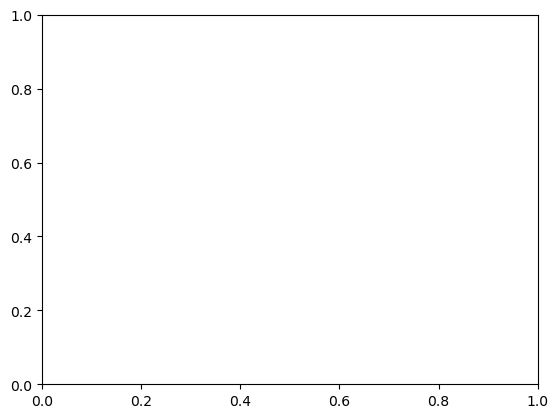

In [50]:
# visualize a pathway
ct.tl.communication_direction(adata, database_name="cellchat", pathway_name="TGFb", k=5)
ct.pl.plot_cell_communication(adata, database_name='cellchat', pathway_name='TGFb', plot_method='grid', background_legend=True, 
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

### HVGs
- simple HVGs
- L&R HVG
- ligand HVG
- receptor HVG
- 5% prevalence

### Unfiltered expression